Copyright (C) 2023 Pablo Castells y Alejandro Bellogín

El código que contine este notebook se ha implementado para la realización de las prácticas de la asignatura "Búsqueda y minería de información" de 4º del Grado en Ingeniería Informática, impartido en la Escuela Politécnica Superior de la Universidad Autónoma de Madrid. El fin del mismo, así como su uso, se ciñe a las actividades docentes de dicha asignatura.

### **Búsqueda y Minería de Información 2022-23**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Grado en Ingeniería Informática, 4º curso

# Bloque 2 - Análisis de redes sociales

Fechas:

* Comienzo: martes 28 / jueves 30 de marzo.
* Entrega: lunes 8 de mayo, 23:59.

## Objetivos

Este segundo bloque de la práctica tiene por objetivo la implementación de funcionalidades de análisis de redes sociales. En este bloque se desarrollarán:

* Métricas que se utilizan en el análisis de redes sociales.
* Otras funcionalidades a elección opcional del estudiante, tales como más métricas, la detección de comunidades, la generación aleatoria de redes sociales, o la recomendación de contactos.

## Material proporcionado

Se proporcionan software y datos para la realización de la práctica:

* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones. De modo similar a las prácticas anteriores, se proporciona una celda de prueba al final, que deberá funcionar con el código implementado por el estudiante.
* Redes sociales de prueba:
  - Tres redes pequeñas de prueba.
  - Redes reales: la red disponible en [SNAP (facebook_combined)](https://snap.stanford.edu/data/egonets-Facebook.html), y <ins>twitter.csv</ins> obtenida mediante una descarga de Twitter (unos 10 mil usuarios con medio millón de relaciones follow).
  - Al conjunto de redes de prueba, el estudiante añadirá dos redes más, simuladas, en el ejercicio 5.
  
Los esqueletos de código que se proporcionan aquí son a modo de guía: el estudiante puede modificarlo todo libremente, siempre que la celda de prueba funcione correctamente **sin cambios**.

## Calificación

El peso de esta práctica (recomendación + redes sociales) en la nota final de prácticas es del **40%**.

La calificación se basará en el **número** de ejercicios realizados y la **calidad** de los mismos. La puntuación que se indica en cada apartado es orientativa, en principio se aplicará tal cual se refleja pero podrá matizarse por criterios de buen sentido si se da el caso.

Para dar por válida la realización de un ejercicio, el código deberá funcionar (a la primera) integrado con las clases que se facilitan. El profesor comprobará este aspecto ejecutando la celda de prueba y otras adicionales.

La corrección de las implementaciones se observará por la **coherencia de los resultados**, y se valorará la eficiencia en tiempo de ejecución.

## Entrega

La entrega consistirá en dos ficheros tipo *notebook* (uno para recomendación y otro para redes sociales) donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

## Indicaciones

La realización de los ejercicios conducirá en muchos casos a la implementación de funciones y/o clases adicionales a las que se indican en el enunciado. Algunas vendrán dadas por su aparición en los propias celdas de prueba, y otras por conveniencia a criterio del estudiante.

Igual que en prácticas anteriores, no deberán editarse las celdas de prueba. Estas celdas deberán ejecutar sin errores a la primera con el código entregado por el estudiante (naturalmente con salvedad de los ejercicios que no se hayan implementado.

## Ejercicio 5: Preliminares (1.5pt)

Generar dos **redes sociales simuladas** siguiendo los modelos de Barabási-Albert y Erdös-Rényi. El tamaño y densidad de los grafos se deja a elección propia. Se puede utilizar para ello cualquier herramienta (como NetworkX, o el entorno interactivo de Gephi), o bien programar implementaciones propias (lo cual también es muy sencillo).

Realizar un análisis básico de la **distribución del grado** en las siete redes sociales de la práctica: small x 3, Facebook, Twitter, Barabási-Albert y Erdös-Rényi. Para cada red:

* Generar una gráfica de distribución del grado (utilizando escala log-log cuando ello sea útil) y comprobar en qué medida se observa una distribución power law.
* Verificar si se observa la paradoja de la amistad (en sus diferentes versiones).

Los resultados de este ejercicio no conllevan entrega de software, sino sólo la documentación de los mismos en el apartado de memoria.

In [23]:
# Si se ha implementado algún código, se puede incluir aquí
# Si no se ha utilizado Python, se puede utilizar el apartado de explicación siguiente para describir el proceso y las herramientas utilizadas

In [31]:
import pandas as pd
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [46]:
file = os.path.join('networks', 'twitter.csv')
df = pd.read_csv(file, names=['u', 'v'], delimiter=',')
df

,u,v
0,celiagnaranjo,012CMadrid
1,CronicaNorte,012CMadrid
2,CanalCAMTV,012CMadrid
3,asociaciondia,012CMadrid
4,kaikuland,012CMadrid
...,...,...
560220,sjw,zsims
560221,kenum,zsims
560222,_mariabg,zsims
560223,StartSpain,zsims


In [47]:
# Creamos la matriz de adyacencia a partir de las conexiones
adjacency_matrix = pd.crosstab(df.u, df.v)
idx = adjacency_matrix.columns.union(adjacency_matrix.index)
adjacency_matrix = adjacency_matrix.reindex(index = idx, columns=idx, fill_value=0)

# Lo convertimos a numpy array
adjacency_matrix = adjacency_matrix.to_numpy()

# Sumamos la transpuesta ya que todos los enlaces son bidireccionales
adjacency_matrix = adjacency_matrix + adjacency_matrix.T

# Eliminamos los enlaces que se repiten (es decir, los que tienen un valor mayor a 1
# después de la suma)
adjacency_matrix[adjacency_matrix > 1] = 1

# Eliminamos los enlaces de un nodo a sí mismo
np.fill_diagonal(adjacency_matrix, 0)

adjacency_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [ ]:
# Sum by rows
nodes_degrees = adjacency_matrix.sum(axis=1)

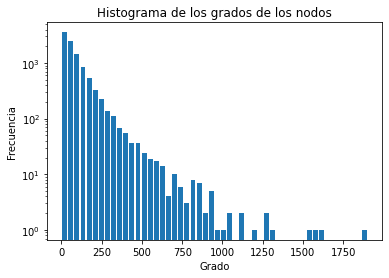

In [75]:
# Histogram with points and infinite bars
plt.hist(nodes_degrees, bins = 50, rwidth=0.8, log=True)
plt.title('Histograma de los grados de los nodos')
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.show()


### Explicación/documentación/imágenes generadas

(por hacer)

## Ejercicio 6: Métricas (1.5pt)

Se implementarán las siguientes métricas topológicas:

* Coeficiente de **clustering de un usuario**.
* **Arraigo** de un arco (o de un par de usuarios).
* Coeficiente de **clustering de una red social**.
* Coeficiente de **asortatividad** de grado de una red.

Algunas indicaciones en forma de pregunta:

* ¿Cómo obtener la red ego de un usuario en una sóla operación de *slicing* del array 2D de adyacencia?
* ¿Cómo calcular la densidad de una red social en *una* sola operación sobre su matriz de adyacencia? 
* ¿Cómo obtener el solapamiento de los amigos de dos usuarios con una sola operación vectorial?
* ¿Cómo obtener la unión de dos vecindarios de forma eficiente sabiendo su solapamiento?

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import os.path
import networkx as nx
from matplotlib import pyplot as plt

class UndirectedSocialNetwork:
    #
    # In order to spare you some routine coding, we provide this constructor for you, 
    # that builds the basic structures you need to implement your metrics: the network 
    # adjacency matrix, the uid <--> uiidx back and forth mappings, and the number of edges.
    #
    # For your purposes you don't need to go into the implementation details or fully
    # understand every step how they are built -- you just need to use the  provided matrix 
    # and id mapping structure.
    #
    def __init__(self, file, sep=','):
        self.file=file
        edges = pd.read_csv(file, names=['u', 'v'], delimiter=sep)
        edges['r'] = np.ones(len(edges))

        # Take the union of uids, as there may be users who only appear in one data frame column and not the other.
        us = edges.u.unique()
        vs = edges.v.unique()
        self.uids = np.union1d(us, vs)
        self.uidxs = {u:j for j, u in enumerate(self.uids)}
        
        # Add dummy columns (with r=0) so that all userids appear in both data frame columns (otherwise they'd fail
        # to have a row or column in the adjacency matrix). 
        udiff = np.setdiff1d(us, vs)
        vdiff = np.setdiff1d(vs, us)
        edges = pd.concat([edges, pd.DataFrame({'u': vdiff, 'v': np.full(len(vdiff), us[0]), 'r': np.zeros(len(vdiff))})])
        edges = pd.concat([edges, pd.DataFrame({'u': np.full(len(udiff), vs[0]), 'v': udiff, 'r': np.zeros(len(udiff))})])
        
        # Get adjacency matrix.
        edges = edges.pivot(index='u', columns='v', values='r')
        self.m = edges.fillna(0).to_numpy(dtype=np.bool_)
        # Make the adjacency matrix symmetric for an undirected network.
        self.m = np.logical_or(self.m, self.m.T).astype(np.float32)
        # We only count the edges now in case the network file contained reciprocal edges for a directed network,
        # in which case we ignored the edge direction, while the csv file contained more rows than the number of
        # undirected edges.
        self._nedges = self.m.sum()/2

    def matrix(self):
        # Código aquí...

    def nusers(self):
        # Código aquí...
    
    def nedges(self):
        # Código aquí...

    def uid_to_uidx(self, uid):
        # Código aquí...
    
    # uidx can be an int of an array of ints.
    def uidx_to_uid(self, uidx):
        # Código aquí...

    def _friends(self, uidx):
        # Código aquí...
    
    #
    # For debugging purposes.
    #
    
    def degree(self, uid):
        # Código aquí...

    def friends(self, uid):
        # Código aquí...
        
    #
    # Network metrics.
    #
    
    # Global computation of the clustering coefficient (micro-average).
    def clustering(self):
        # Código aquí...

    def assortativity(self):
        # Código aquí...

    #
    # User metrics.
    #
    
    # Network clustering coefficient as the average clustering coefficient of users.
    def avg_clustering(self):
        return UserMetric(self, np.array([self.user_clustering(uidx) for uidx in range(self.nusers())]))

    # Clustering coefficient of individual user - just needed for the average CC.
    def user_clustering(self, uidx):
        # Código aquí...

    #
    # Edge metrics.
    #
    
    def embeddedness(self):
        # Código aquí...
        return EdgeMetric(self, intersections / unions)

#
# Auxiliary classes to hold and return values of user metrics and edge metrics.
#
    
# Aiming to spare you some routine coding, the purpose of these two classes is 
# to hold the metric values through their constructur, and return the mean and 
# ranked values of user and edge metrics when requested. 
#
# For your purposes you don't need to go into the implementation details, or
# understand every step of these functions -- you just need to use the simple
# API they provide.
    
class UserMetric:
    def __init__(self, network, values):
        self.network = network
        self._values = values
        self.sorted_uidx = (rankdata(-values, method='ordinal')).argsort()

    # Return the mean value across all users in the network.
    def mean(self):
        return self._values.mean()

    # Return the metric value for one user.
    def value(self, uid):
        return self._values[self.network.uid_to_uidx(uid)]

    # Return a dictionary with the top n users in the metric.
    def values(self, n):
        return {l:fround(v, 4) for l, v in zip(self.network.uids[self.sorted_uidx[:n]],
                                                   self._values[self.sorted_uidx[:n]])}

class EdgeMetric:
    def __init__(self, network, values):
        self.network = network
        values[np.tril_indices(values.shape[0])] = np.iinfo(int).min
        self._values = values
        tri = int(network.nusers() * (network.nusers() - 1) / 2)
        self.order = np.dstack(np.unravel_index(np.argsort(rankdata(-values.ravel(), method='ordinal')), values.shape))[0][:tri]
        self.ordered_values = np.array([self._values[e[0],e[1]] for e in self.order])

    # Return the mean value across all edges in the network.
    def mean(self):
        return self.ordered_values.mean()

    # Return the metric value for one edge (the edge may or may not exist).
    def value(self, uid, vid):
        uidx, vidx = self.network.uid_to_uidx(uid), self.network.uid_to_uidx(vid)
        return self._values[min(uidx, vidx), max(uidx, vidx)]

    # Return a dictionary with the top n edges in the metric.
    def values(self, n):
        n = min(n, len(self.order))
        return {tuple(self.network.uidx_to_uid(e)):fround(self._values[e[0],e[1]], 4) for e in self.order[:n]}
    
# Just for pretty-printing numbers.
def fround(x, n=20):
    r = round(x)
    rn = round(x, n)
    return r if rn == r else rn

IndentationError: expected an indented block (3843091388.py, line 49)

### Explicación/documentación

(por hacer)

Además, se documentarán en la memoria los tiempos de ejecución de las métricas en las redes de Facebook y Twitter, en una tabla con la siguiente estructura:

||Facebook|Twitter
|-|:-:|:-:
|Coef. clustering usuario|...|... 
|Embededness|...|...
|Coef. clustering global|...|...
|Asortatividad|...|...

## Ejercicio 7: Ejercicio libre (fuera de puntuación)

El estudiante desarrollará uno o varios métodos de análisis de redes a su propia elección. Se sugiere por ejemplo: 

* Implementación de métricas adicionales, tales como betweenness, closeness, distancia promedio, diámetro, modularidad, etc. (Para la modularidad, se necesitará definir una partición de los nodos &ndash; consultar con el profesor.)
* Detección de comunidades y enlaces débiles.
* Creación de modelos para la generación aleatoria de redes sociales (p.e. amigos de amigos, etc.).
* Recomendación de contactos.

Para este ejercicio deberá completarse la implementación de una función adicional `student_test()` ilustrando la ejecución de las métricas y algoritmos implementados. 

El software que se desarrolle se incluirá en la celda que sigue, y se documentarán en la memoria las pruebas realizadas y los resultados obtenidos. 

Este ejercicio se evaluará en base a la cantidad, calidad e interés del trabajo realizado.

In [ ]:
# Implementación o implementaciones elegidas

In [ ]:
def student_test(data):
    pass
    # Código aquí...

### Explicación/documentación

(por hacer)

## Visualización de las redes pequeñas de prueba

Descarga los ficheros del curso de Moodle y coloca sus contenidos en una carpeta **networks** en el mismo directorio que este *notebook*. Visualizar las redes de prueba facilita las comprobaciones que puedan ser necesarias durante la depuración del código.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import os.path
import networkx as nx
from matplotlib import pyplot as plt

networks/toy1.html
networks/toy2.html
networks/toy3.html


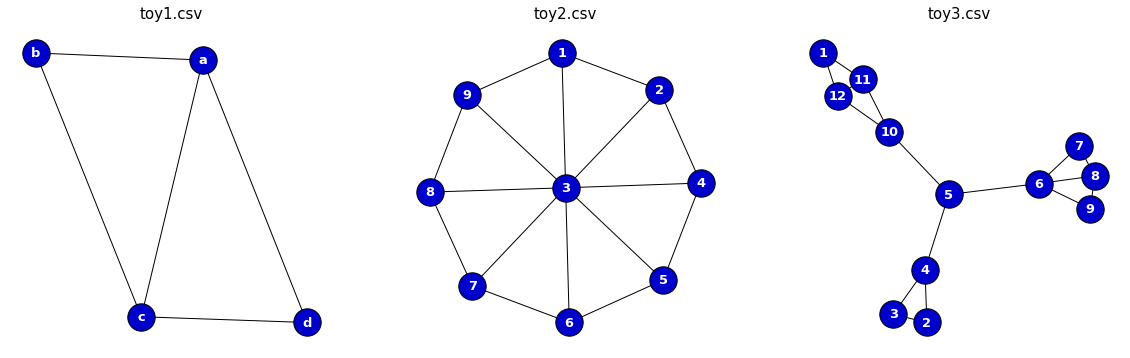

In [ ]:
from pyvis.network import Network

def plot(file, ax=None, sep=','):
    g = nx.from_pandas_edgelist(pd.read_csv(file, names=['u', 'v'], delimiter=sep), 
                                source='u', target='v')
    options = {
        'node_size': 750, 'node_color': 'mediumblue', 'edgecolors': "black",
        'font_color': 'white', 'font_weight': 'bold', 'font_size': 13
    }
    if not ax: 
        f = plt.figure()
        f.set_size_inches(3, 3)
        
    # Plot the graphs in the output cell.
    nx.draw(g, ax=ax, with_labels=True, **options)
    filename = os.path.split(file)[1]
    (ax if ax else plt.gca()).set_title(filename, fontsize=15)
    
    # Plot the graphs into interactive HTML files.
    net = Network(notebook=True, cdn_resources='remote')
    net.from_nx(g)
    net.show(file.split('.')[0] + '.html')
    

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(20, 6)
plot('networks/toy1.csv', ax1)
plot('networks/toy2.csv', ax2)
plot('networks/toy3.csv', ax3)

## Celda de prueba

In [ ]:
import datetime, time

def test_network(file, topn, example_u, example_v, sep=','):
    print(f'==================================================\nTesting {file} network')
    network = UndirectedSocialNetwork(file, sep=sep)
    print(f'Network matrix takes {round(10 * network.matrix().nbytes / 1024 / 1024) / 10:,} MB in RAM')
    print(f'{network.nusers():,} users and {network.nedges():,} contact relationships')
    print(f'User {example_u} has {network.degree(example_u):,} contacts: ', network.friends(example_u))
    print('-------------------------')
    start = time.time()
    c = network.avg_clustering()
    print(f'User clustering coefficient (top {topn}): {c.values(5)}')
    print(f'  CC({example_u}) =              {c.value(example_u)}')
    print('Network clustering coefficient:')
    print(f'  Macro-average =      {c.mean()}')  
    start = timer(start)
    print(f'  Micro-average =      {network.clustering()}')
    start = timer(start)
    print(f'Assortativity =        {network.assortativity()}')
    start = timer(start)
    e = network.embeddedness()
    print(f'Edge embeddedness (top {topn}): {e.values(5)}')
    print(f'  Embeddedness({example_u}, {example_v}) = {e.value(example_u, example_v)}')
    print(f'  Average =            {e.mean()}')
    timer(start)

    # Otros tests?
    student_test(network)

from termcolor import colored
def timer(start):
    print(colored(f'  --> elapsed time: {datetime.timedelta(seconds=round(time.time() - start))} <--', 'blue'))
    return time.time()
    
test_network('networks/toy1.csv',              topn=5, example_u='a',       example_v='b')
test_network('networks/toy2.csv',              topn=5, example_u=5,         example_v=6)
test_network('networks/toy3.csv',              topn=5, example_u=6,         example_v=4)
test_network('networks/facebook_combined.txt', topn=5, example_u=9,         example_v=3, sep=' ')
test_network('networks/twitter.csv',           topn=5, example_u='el_pais', example_v='ElviraLindo') # Contains a number of reciprocal edges but we ignore direction.
test_network('networks/barabasi.csv',          topn=5, example_u=2000,         example_v=3000)
test_network('networks/erdos.csv',             topn=5, example_u=2000,         example_v=3000)
print('==================================================\nDone.')

Testing networks/toy1.csv network


NameError: name 'UndirectedSocialNetwork' is not defined

### Salida obtenida por el estudiante

*(por hacer)*